## DIALS Output Analysis

In [77]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
from libtbx.phil import parse

from dials.command_line import dials_import
from dials.command_line import find_spots
from dials.command_line import index
from dials.command_line import refine
from dials.command_line import tof_integrate

from dials.util import log

from dials.array_family.flex import reflection_table
from dxtbx.model.experiment_list import ExperimentListFactory

import math
import matplotlib.pyplot as plt
import pandas as pd
import nmx_workflow.refl_loader

## Spotfinding Analysis

In [127]:
reflections = nmx_workflow.refl_loader.load('/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/strong.refl')
experiments = ExperimentListFactory.from_json_file('/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/imported.expt')

<class 'str'>


In [128]:
refls_df = pd.DataFrame(reflections['xyzobs.px.value'])
refls_df['id'] = reflections['id']
refls_df.columns = ['x','y','z','id']

In [136]:
refls_df[refls_df['id'] == 1]


,x,y,z,id
1283,1063.268512,510.059649,5.5,1
1284,1191.653444,592.859719,5.5,1
1285,1011.699572,680.270159,4.5,1
1286,1191.358261,687.235673,5.5,1
1287,1063.226784,769.856364,5.5,1
...,...,...,...,...
2673,704.467591,279.298555,47.5,1
2674,712.660614,441.666956,47.5,1
2675,712.567775,838.359640,47.5,1
2676,704.501749,1000.890069,47.5,1


In [80]:
zz = refls_df['z']
min_z = zz.min()
max_z = zz.max()
xmin = math.ceil(min_z)
xmax = math.ceil(max_z)
nimg = xmax - xmin + 1
nimg

48

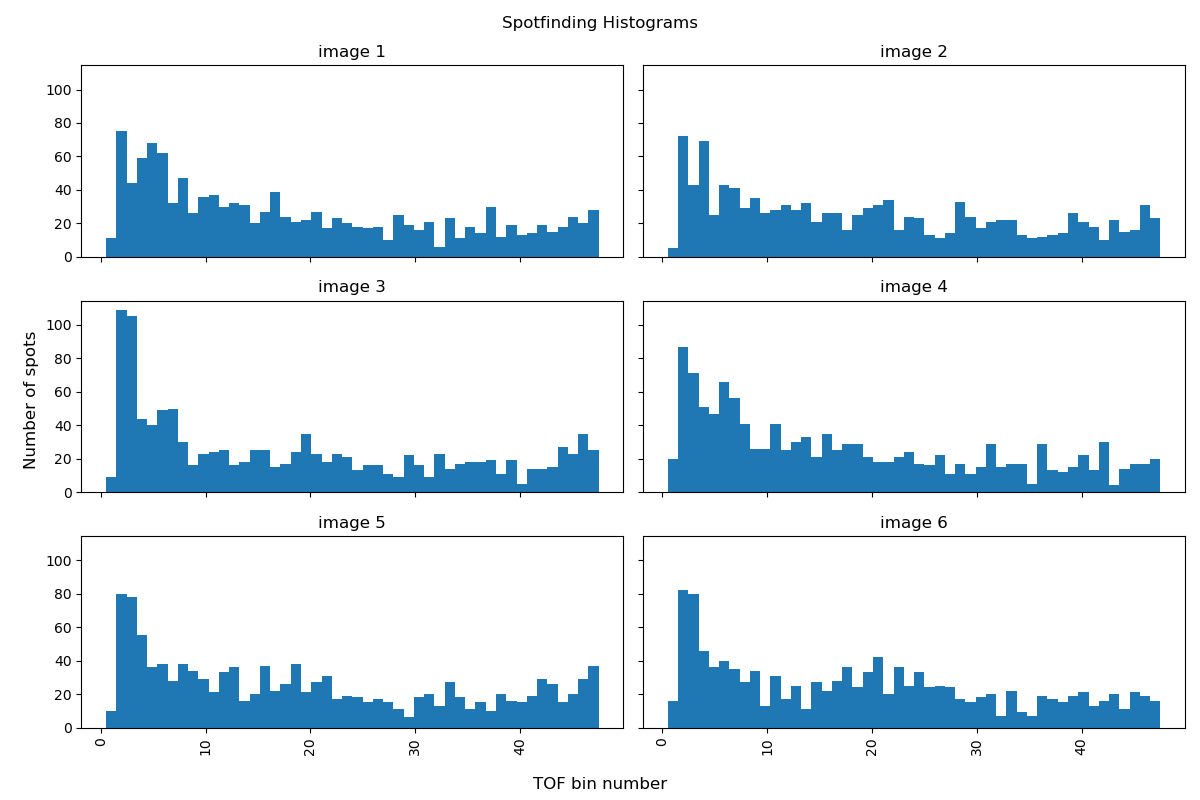

In [19]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True, figsize=(12,8))

fig.supxlabel('TOF bin number')
fig.supylabel('Number of spots')
fig.suptitle('Spotfinding Histograms')

findspots_hist = refls_df.hist('z',by='id', ax=axes, bins=nimg)

findspots_hist = findspots_hist.flatten()

for i, ax in enumerate(findspots_hist):
    ax.set_title(f'image {i+1}')

plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display



In [139]:
import plotly.io as pio
import json
from nmx_workflow.config import INTERIM_DATA_DIR

# Group histograms by 'id'
unique_ids = refls_df['id'].unique()
histograms = {}

def get_nimg_bins(refls_df):
    zz = refls_df['z']
    min_z = zz.min()
    max_z = zz.max()
    xmin = math.ceil(min_z)
    xmax = math.ceil(max_z)
    nimg = xmax - xmin + 1
    return nimg


# Generate histograms for each unique 'id'
for uid in unique_ids:
    fig, ax = plt.subplots()
    nspots = len(refls_df[refls_df['id'] == uid])
    counts, bins, _ = ax.hist(refls_df[refls_df['id'] == uid]['z'], bins=get_nimg_bins(refls_df))
    plt.close(fig)  # Close Matplotlib figure

    # Convert to Plotly Figure
    fig_plotly = go.Figure()
    fig_plotly.add_trace(go.Bar(x=bins[:-1], y=counts, width=np.diff(bins), name=f'ID {uid}'))
    fig_plotly.update_layout(title=f'Spotfinding Histogram for Image {uid} ({nspots} spots found)', xaxis_title="TOF bin number", yaxis_title="Strong spots found")
    
    histograms[str(uid)] = fig_plotly

# Create tabs for each histogram
tab_titles = list(histograms.keys())
tab_contents = [widgets.Output() for _ in tab_titles]

# Fill each tab with its respective Plotly histogram
for i, output in enumerate(tab_contents):
    with output:
        display(histograms[tab_titles[i]])

# Create tab widget
tabs = widgets.Tab(children=tab_contents)
for i, title in enumerate(tab_titles):
    tabs.set_title(i, f'Image {title}')  # Set tab labels

# Save histograms to JSON
histogram_json = {}
for uid, fig in histograms.items():
    histogram_json[uid] = json.loads(pio.to_json(fig))

# Save to a file
with open(INTERIM_DATA_DIR/'spotfinding.json','w') as f:
    json.dump(histogram_json, f)
# Display tabs
display(tabs)


In [56]:
indexed_refls = nmx_workflow.refl_loader.load('/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/indexed.refl')
indexed_expt = ExperimentListFactory.from_json_file('/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/indexed.expt')

<class 'str'>


In [ ]:
expt_0 = indexed_refls[indexed_refls['imageset_id'] == 0]

TypeError: unhashable type: 'numpy.ndarray'

In [63]:
del indexed_refls['experiment_identifier']

In [72]:
idx_df = pd.DataFrame({
    key: list(val) if isinstance(val, np.ndarray) and val.ndim > 1
    else val
    for key, val in indexed_refls.items()
    })
len(idx_df[(idx_df['imageset_id']==0) & (idx_df['id']==0)])


1257

In [115]:
results_dict = {}
for i in range(5):
    uc = indexed_expt[0].crystal.get_unit_cell().parameters()
    unit_cell = "{0:.2f}, {1:.2f}, {2:.2f}, {3:.1f}, {4:.1f}, {5:.1f}".format(uc[0],uc[1],uc[2],uc[3],uc[4],uc[5])
    percent_indexed = len(idx_df[(idx_df['imageset_id']==i) & (idx_df['id']==i)]) / len(idx_df[(idx_df['imageset_id']==i)])
    results_dict[i] = {
        "Unit cell": unit_cell,
        "Space group": str(indexed_expt[0].crystal.get_space_group().info()),
        "# indexed": len(idx_df[(idx_df['imageset_id']==i) & (idx_df['id']==i)]),
        "# unindexed": len(idx_df[(idx_df['imageset_id']==i) & (idx_df['id']==-1)]),
        "% indexed": round(percent_indexed*100,1)
    }
with open(INTERIM_DATA_DIR / 'indexing.json','w') as fp:
    json.dump(results_dict,fp)

In [116]:
import json
import re

# File paths
LOG_FILE_PATH = "/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/dials.refine.log"
OUTPUT_JSON_PATH = "/Users/aaronfinke/nmx_workflow/nmx_workflow/data/interim/refine_summary.json"

def parse_summary(log_file_path):
    """Parse the summary tables from the dials.refine.log file."""
    summaries = {}
    current_experiment = None
    summary_pattern = re.compile(r"Summary for experiment (\d+)")
    table_row_pattern = re.compile(r"\| ([^|]+?)\s+\|\s+([\d\.\-]+)\s+\|\s+([\d\.\-]+)\s+\|\s+([\d\.\-]+)\s+\|")

    with open(log_file_path, "r") as file:
        for line in file:
            # Check for the start of a new experiment summary
            match = summary_pattern.search(line)
            if match:
                current_experiment = int(match.group(1))
                summaries[current_experiment] = []
                continue

            # Parse rows in the summary table
            if current_experiment is not None:
                row_match = table_row_pattern.search(line)
                if row_match:
                    item = row_match.group(1).strip()
                    overall = row_match.group(2).strip()
                    low = row_match.group(3).strip()
                    high = row_match.group(4).strip()
                    summaries[current_experiment].append({
                        "item": item,
                        "overall": overall,
                        "low": low,
                        "high": high
                    })

    return summaries

def save_to_json(data, output_path):
    """Save the parsed data to a JSON file."""
    with open(output_path, "w") as json_file:
        json.dump(data, json_file, indent=4)

# Parse the log file and save the JSON
parsed_data = parse_summary(LOG_FILE_PATH)
save_to_json(parsed_data, OUTPUT_JSON_PATH)

print(f"Summary data saved to {OUTPUT_JSON_PATH}")

Summary data saved to /Users/aaronfinke/nmx_workflow/nmx_workflow/data/interim/refine_summary.json


In [158]:
import json
import re

# File paths
LOG_FILE_PATH = "/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/dials/dials.tof_integrate.log"
OUTPUT_JSON_PATH = "/Users/aaronfinke/nmx_workflow/nmx_workflow/data/interim/tof_integrate_summary.json"
image_rows = ["ID","Image","# full","# part","# over","# ice","# sum","# prf","Ibg","I/sigI (sum)","I/sigI (prf)","CC prf","RMSD XY"]
dmin_rows = ["ID","dmin","# full","# part","# over","# ice","# sum","# prf","Ibg","I/sigI (sum)","I/sigI (prf)","CC prf","RMSD XY"]

def parse_log_file(log_file_path):
    data = {}
    current_section = None

    with open(log_file_path, "r") as file:
        for line in file:
            # Detect section headers
            if "Summary vs image number"in line:
                for _ in range(5):
                    line = next(file)
                current_section = "image_summary"
                data[current_section] = {}
                for name in image_rows:
                    data[current_section][name] = []
            elif "Summary vs resolution"in line:
                for _ in range(5):
                    line = next(file)
                current_section = "resolution_summary"
                data[current_section] = {}
                for name in dmin_rows:
                    data[current_section][name] = []
            elif "Summary for experiment"in line:
                match = re.search(r"Summary for experiment (\d+)", line)
                if match:
                    current_section = f"experiment_{match.group(1)}"
                    data[current_section] = []

            # Parse table rows
            if current_section in ["image_summary", "resolution_summary"] and "|"in line and not line.startswith("+"):
                # Split the row into columns
                columns = [col.strip() for col in line.split("|")[1:-1]]
                data_rows = image_rows if current_section == "image_summary" else dmin_rows
                for name, result in zip(data_rows,columns):
                    data[current_section][name].append(result)

            # Parse experiment summaries
            if current_section and current_section.startswith("experiment_") and "|" in line and not line.startswith("+"):
                # Split the row into key-value pairs
                columns = [col.strip() for col in line.split("|")[1:-1]]
                if len(columns) == 4:
                    key, overall, low, high = columns[0], columns[1], columns[2], columns[3]
                    data[current_section].append({
                        "item": key,
                        "overall": overall,
                        "low": low,
                        "high": high
                    })

    return data

def save_to_json(data, output_path):
    """Save the parsed data to a JSON file."""
    with open(output_path, "w") as json_file:
        json.dump(data, json_file, indent=4)

def convert_to_dataframes(parsed_data):
    """Convert parsed data into pandas DataFrames."""
    dataframes = {}
    if "image_summary" in parsed_data:
        dataframes["image_summary"] = pd.DataFrame(parsed_data["image_summary"])
    if "resolution_summary" in parsed_data:
        dataframes["resolution_summary"] = pd.DataFrame(parsed_data["resolution_summary"])
    for key in parsed_data:
        if key.startswith("experiment_"):
            dataframes[key] = pd.DataFrame(parsed_data[key])
    return dataframes


# Parse the log file and save the JSON
parsed_data = parse_log_file(LOG_FILE_PATH)
save_to_json(parsed_data, OUTPUT_JSON_PATH)

print(f"Summary data saved to {OUTPUT_JSON_PATH}")

Summary data saved to /Users/aaronfinke/nmx_workflow/nmx_workflow/data/interim/tof_integrate_summary.json


In [203]:
df = convert_to_dataframes(parsed_data)


In [ ]:
df['resolution_summary'] = df['resolution_summary'].astype({
    'ID': 'int',
    'dmin':'float',
    '# full':'int',
    '# part':'int',
    '# over':'int',
    '# ice':'int',
    '# sum':'int',
    '# prf':'int',
    'Ibg':'float',
    'I/sigI (sum)':'float',
    'I/sigI (prf)':'float',
    'CC prf':'float',
    'RMSD XY':'float'
})
df['image_summary'] = df['image_summary'].astype({
    'ID': 'int',
    'Image':'int',
    '# full':'int',
    '# part':'int',
    '# over':'int',
    '# ice':'int',
    '# sum':'int',
    '# prf':'int',
    'Ibg':'float',
    'I/sigI (sum)':'float',
    'I/sigI (prf)':'float',
    'CC prf':'float',
    'RMSD XY':'float'
})


dtype('int64')

In [ ]:
import plotly.graph_objects as go

# Filter the DataFrame for ID == '0'
filtered_res_df = df_res[df_res['ID'] == 0]
filtered_img_df = df_img[df_img['ID'] == 0]

def generate_res_figure(df, i):
    df_res = df['resolution_summary']
    filtered_res_df = df_res[df_res['ID'] == i]
    # Create the figure
    fig_res = go.Figure()

    # Add the first y-axis trace (I/sigI (sum))
    fig_res.add_trace(
        go.Scatter(
            x=filtered_res_df['dmin'],
            y=filtered_res_df['I/sigI (sum)'],
            mode='markers+lines',
            name='I/sigI (sum)',
            marker=dict(color='blue')
        )
    )

    # Add the second y-axis trace (RMSD XY)
    fig_res.add_trace(
        go.Scatter(
            x=filtered_res_df['dmin'],
            y=filtered_res_df['RMSD XY'],
            mode='markers+lines',
            name='RMSD XY',
            marker=dict(color='red'),
            yaxis='y2'  # Specify the second y-axis
        )
    )

    # Update layout for dual y-axes
    fig_res.update_layout(
        title="Intensity/RMSD vs. Resolution",
        xaxis=dict(
            title="dmin (Å)", 
            autorange="reversed",
            tickangle=0),
        yaxis=dict(
            title="I/sigI (sum)",
            tickfont=dict(color="blue"),
            tickformat=".0f",
            dtick= filtered_res_df['I/sigI (sum)'].max() / 5,

        ),
        yaxis2=dict(
            title="RMSD XY",
            tickfont=dict(color="red"),
            overlaying="y",
            side="right",
            dtick=filtered_res_df['RMSD XY'].max() / 5
        ),
        legend=dict(x=0.1, y=1.1),
        template="plotly_white"
    )
    return fig_res

def generate_img_figure(filtered_img_df, i):
    df_img = df['image_summary']
    filtered_img_df = df_img[df_img['ID'] == i]

    # Create the figure
    fig_img = go.Figure()

    # Add the first y-axis trace (I/sigI (sum))
    fig_img.add_trace(
        go.Scatter(
            x=filtered_img_df['Image'],
            y=filtered_img_df['I/sigI (sum)'],
            mode='markers+lines',
            name='I/sigI (sum)',
            marker=dict(color='blue')
        )
    )

    # Add the second y-axis trace (RMSD XY)
    fig_img.add_trace(
        go.Scatter(
            x=filtered_img_df['Image'],
            y=filtered_img_df['RMSD XY'],
            mode='markers+lines',
            name='RMSD XY',
            marker=dict(color='red'),
            yaxis='y2'  # Specify the second y-axis
        )
    )

    # Update layout for dual y-axes
    fig_img.update_layout(
        title="Intensity/RMSD vs. Image Number",
        xaxis=dict(
            title="Image Number", 
            tickangle=0),
        yaxis=dict(
            title="I/sigI (sum)",
            tickfont=dict(color="blue"),
            tickformat=".0f",
            dtick= filtered_img_df['I/sigI (sum)'].max() / 5,

        ),
        yaxis2=dict(
            title="RMSD XY",
            tickfont=dict(color="red"),
            overlaying="y",
            side="right",
            dtick=filtered_img_df['RMSD XY'].max() / 5
        ),
        legend=dict(x=0.1, y=1.1),
        template="plotly_white"
    )
    return fig_img


In [216]:
integrate_plots = {}
unique_ids = df['resolution_summary']['ID'].unique()

for uid in unique_ids:
    integrate_plots[str(uid)] = {}
    fig_res = generate_res_figure(df, uid)
    fig_img = generate_img_figure(df, uid)
    integrate_plots[str(uid)]['fig_res'] = json.loads(pio.to_json(fig_res))
    integrate_plots[str(uid)]['fig_img'] = json.loads(pio.to_json(fig_img))

with open(INTERIM_DATA_DIR/"integration.json",'w') as fp:
    json.dump(integrate_plots,fp, indent=4)